In [1]:
#!pip install -U tensorflow

In [187]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# organise data

In [66]:
df = pd.read_csv('../raw_data/cassava-leaf-disease-classification/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [67]:
num_classes = len(df.label.unique())

In [68]:
import json
label_map = json.load(open('../raw_data/cassava-leaf-disease-classification/label_num_to_disease_map.json'))
label_map


{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [69]:
label_map = {'0': 'cassava_bacterial_blight',
 '1': 'cassava_brown_streak_disease',
 '2': 'cassava_green_mottle',
 '3': 'cassava_mosaic_disease',
 '4': 'healthy'}

In [70]:
df['label_text'] = df.label.astype(str).map(label_map)

# Get Data

In [7]:
labels_list = df.sort_values('image_id').label.values.tolist()

### Load from GCP

In [172]:
from google.cloud import storage
from PIL import Image
import io

def get_data_from_gcp():
    
    class_names = ['cassava_bacterial_blight', 
                    'cassava_brown_streak_disease',
                    'cassava_green_mottle',
                    'cassava_mosaic_disease',
                    'healthy']
    
    client = storage.Client()

    bucket = client.get_bucket("image-datasets-alecsharpie")
    
    
    all_images = []
    all_targets = []
    
    for class_id, class_name in enumerate(class_names):

        blobs = bucket.list_blobs(prefix=f"cassava_farmer/train_images/{class_name}")
        
        images = []
        
        print(f"fetching {class_name} images...")
        class_count = 0
        for idx, bl in enumerate(blobs):
            # skip folder path
            if idx == 0:
                continue
            if idx % 100 == 0:
                print(f"{idx}")
            data = bl.download_as_string()
            images.append(data)
            class_count = class_count + 1

        images = [np.array(Image.open(io.BytesIO(img_bytes))) for img_bytes in images]
        
        targets = [class_id]  * class_count
        
        all_images = all_images + images
        
        all_targets = all_targets + targets
    
    return np.array(all_images), np.array(all_targets)

In [173]:
X, y = get_data_from_gcp()

fetching cassava_bacterial_blight images...
100
200
300
400
500
600
700
800
900
1000
fetching cassava_brown_streak_disease images...


KeyboardInterrupt: 

In [ ]:
X.shape, y.shape

### load from local

In [ ]:
#'/Users/alecsharp/me/cassava_farmer/raw_data/cassava-leaf-disease-classification/train_images'

train_path = '../raw_data/cassava-leaf-disease-classification/train_images'
batch_size = 32

from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    train_path, batch_size=32, subset='training', validation_split=.20, seed = 42, image_size=(512, 512),
)

class_names = train_ds.class_names
print(train_ds)
print(train_ds.cardinality())

train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(batch_size)
train_ds = train_ds.repeat()


val_ds = image_dataset_from_directory(
    train_path, batch_size=32, subset='validation', validation_split=.20, seed = 42, image_size=(512, 512)
)

val_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(batch_size)
val_ds = val_ds.repeat()


Found 21397 files belonging to 5 classes.
Using 17118 files for training.


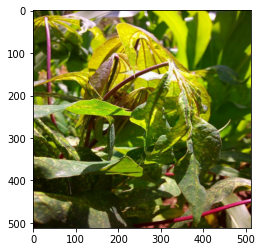

In [113]:
x, y = next(iter(train_ds))
image = x[0, :, :, :]

#print(image)
image = tf.cast(image, 'uint8')

#plt.imshow(image)
plt.imshow(image)

# Transfer learning

In [32]:
#!pip install tensorflow_hub

In [33]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

In [34]:
model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


In [43]:
def build_dataset(path, subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split=.20,
        subset=subset,
        label_mode = 'categorical',
        # Seed needs to provided when using validation_split and shuffle = True.
        # A fixed seed is used so that the validation set is stable across runs.
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=32)

train_ds = build_dataset(train_path, "training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

# normalization_layer = tf.keras.layers.Rescaling(1. / 255)
# preprocessing_model = tf.keras.Sequential([normalization_layer])

# do_data_augmentation = True

# if do_data_augmentation:
#     preprocessing_model.add(tf.keras.layers.RandomRotation(40))
#     preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
#     preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
#     # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
#     # image sizes are fixed when reading, and then a random zoom is applied.
#     # If all training inputs are larger than image_size, one could also use
#     # RandomCrop with a batch size of 1 and rebatch later.
#     preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
#     preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# train_ds = train_ds.map(lambda images, labels:
#                         (preprocessing_model(images), labels))

val_ds = build_dataset(train_path, "validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
# val_ds = val_ds.map(lambda images, labels:
#                     (normalization_layer(images), labels))

Found 21397 files belonging to 5 classes.
Using 17118 files for training.
Found 21397 files belonging to 5 classes.
Using 4279 files for validation.


### Create transfer learning efficientnet model

In [189]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

In [190]:
image_shape = (512, 512, 3)
output_classes = 5

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomRotation(40),
    tf.keras.layers.RandomTranslation(0, 0.2),
    tf.keras.layers.RandomTranslation(0.2, 0),
    tf.keras.layers.RandomZoom(0.2, 0.2),
    tf.keras.layers.RandomFlip(mode="horizontal")
])

from tensorflow.keras.applications.efficientnet import EfficientNetB0

dummy_input = tf.keras.layers.Input(shape=image_shape)

topless_efficient_net = EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=dummy_input, pooling = 'max'
)

aug_eff_model = tf.keras.Sequential([tf.keras.layers.Resizing(512, 512),
                    augmentation,
                    topless_efficient_net,
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(5, activation = 'softmax')])


top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

aug_eff_model.compile(optimizer = 'adam',
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy', top3_acc])

aug_eff_model.build((None, 512, 512, 3))
aug_eff_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_13 (Resizing)      (None, 512, 512, 3)       0         
                                                                 
 sequential_21 (Sequential)  (None, 512, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_13 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [192]:
aug_eff_model.layers[2].trainable = False

# Check the trainable status of the individual layers
for layer in aug_eff_model.layers:
    print(layer, layer.trainable)


NameError: name 'model' is not defined

In [52]:
# # finetune transfer model

# classifier = hub.load(model_handle)

# do_fine_tuning = False

# print("Building model with", model_handle)
# model = tf.keras.Sequential([
#     # Explicitly define the input shape so the model can be properly
#     # loaded by the TFLiteConverter
#     tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
#     processing_augmentation,
#     hub.KerasLayer(model_handle, trainable=do_fine_tuning),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(num_classes,
#                           kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation = 'softmax')
# ])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              207615832 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 6,405
Non-trainable params: 207,615,832
_________________________________________________________________


In [53]:
# for layer in model.layers:
#     print(layer, layer.trainable)

<keras.engine.sequential.Sequential object at 0x15f0ba220> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x15f0f3400> False
<keras.layers.core.dropout.Dropout object at 0x15f074880> True
<keras.layers.core.dense.Dense object at 0x15ea91100> True


In [54]:
# model.compile(
#     optimizer = 'adam',
#     #optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
#     loss = 'categorical_crossentropy',
#     #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
#     metrics=['accuracy'])

### Homemade model

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D

# Model architechture
model = Sequential()

model.add(processing_augmentation)

model.add(Conv2D(32, (3, 3), input_shape=(512, 512, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.24))
model.add(Dense(5,activation='softmax'))

model.summary()

In [ ]:
model.compile(
    optimizer = 'adam',
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
    loss = 'categorical_crossentropy',
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])

In [124]:
aug_eff_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 512, 512, 3)       0         
                                                                 
 sequential_14 (Sequential)  (None, 512, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [123]:
# for layer in model.layers[:]:
#     layer.trainable = False

# Check the trainable status of the individual layers
for layer in aug_eff_model.layers:
    print(layer, layer.trainable)


<keras.layers.preprocessing.image_preprocessing.Resizing object at 0x1560692e0> True
<keras.engine.sequential.Sequential object at 0x1557415e0> True
<keras.engine.functional.Functional object at 0x155338e20> True
<keras.layers.core.dropout.Dropout object at 0x156069490> True
<keras.layers.core.dense.Dense object at 0x156069550> True


In [ ]:
x, y = next(iter(val_ds))
print(x.shape)
print(y.shape)

In [ ]:
x, y = next(iter(train_ds))
print(x.shape)
print(y.shape)

## Train model

In [54]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size
aug_eff_hist = aug_eff_model.fit(
    train_ds,
    epochs=1, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

16/16 [==============================] - 1104s 69s/step - loss: 4.2293 - accuracy: 0.5391 - val_loss: 3.8505 - val_accuracy: 0.5938


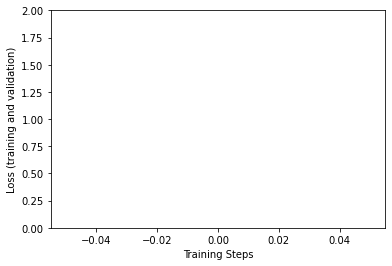

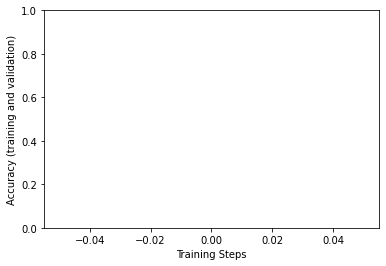

In [56]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(aug_eff_hist["loss"])
plt.plot(aug_eff_hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(aug_eff_hist["accuracy"])
plt.plot(aug_eff_hist["val_accuracy"])

## Test, Save, and load

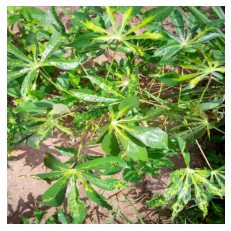

True label: cassava_bacterial_blight
Predicted label: cassava_mosaic_disease
[[2.3794140e-11 2.8640703e-09 2.7029455e-04 9.9972957e-01 6.8891580e-08]]


In [110]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
image = tf.cast(image, 'uint8')
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = aug_eff_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])
print(prediction_scores)

In [120]:
# # Create and train a new model instance.
# #model = create_model()
# #model.fit(train_images, train_labels, epochs=5)

# # Save the entire model as a SavedModel.
# #!mkdir -p saved_model
# aug_eff_model.save('../saved_models/aug_eff_model1')

In [116]:
aug_eff_model.save('../saved_models/aug_eff_model1', save_format='h5')

/Users/alecsharp/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [174]:
loaded_model = tf.keras.models.load_model('../saved_models/aug_eff_model1')

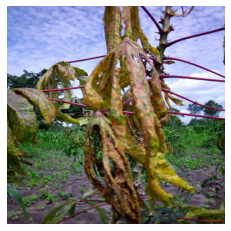

True label: cassava_bacterial_blight
Predicted label: cassava_mosaic_disease
[[3.2980112e-11 4.5966531e-10 7.0918060e-04 9.9929082e-01 4.4121617e-09]]


In [175]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
image = tf.cast(image, 'uint8')
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = loaded_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])
print(prediction_scores)